In [ ]:
import numpy as np # çok boyutlu liste
import pandas as pd # listeleri dataframe e aktarmak için
import matplotlib.pyplot as plt # görselleştirme için ikisi
import seaborn as sns
import itertools # burdan string dahil olacak şekilde önişleme adımları için
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # model dönüştürme için
from sklearn.decomposition import TruncatedSVD # metin indirgeme aşamasındaki boyut indirgeme için
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

color = sns.color_palette()
%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train datasetindeki satır sayısı : ", train_df.shape[0])
print("Test datasetindeki satır sayısı : ", test_df.shape[0])

Train datasetindeki satır sayısı :  19579
Test datasetindeki satır sayısı :  8392


In [ ]:
train_df.tail()

,id,text,author
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP
19578,id00393,"He laid a gnarled claw on my shoulder, and it ...",HPL


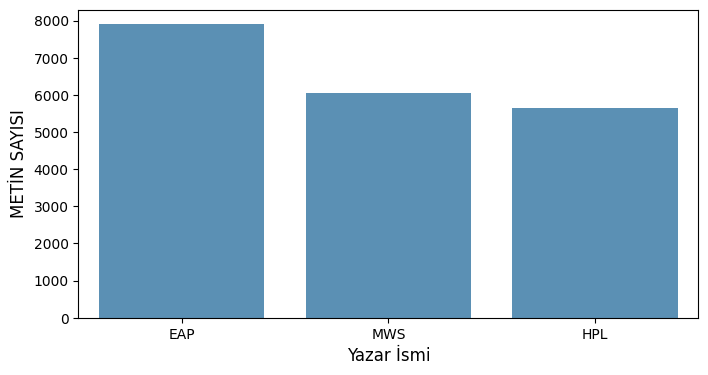

In [ ]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('METİN SAYISI', fontsize=12)
plt.xlabel('Yazar İsmi', fontsize=12)
plt.show()

In [ ]:
## Metindeki kelimelerin lemmatizasyonu ##
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

## Metindeki kelime sayısı ##
train_df["kelime_sayisi"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["kelime_sayisi"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Metindeki benzersiz kelime sayısı ##
train_df["benzersiz_kelime_sayisi"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["benzersiz_kelime_sayisi"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Metindeki karakter sayısı ##
train_df["karakter_sayisi"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["karakter_sayisi"] = test_df["text"].apply(lambda x: len(str(x)))

## Metindeki durak kelime sayısı ##
train_df["durak_kelime_sayisi"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["durak_kelime_sayisi"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Metindeki noktalama işareti sayısı ##
train_df["noktalama_isareti_sayisi"] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df["noktalama_isareti_sayisi"] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

## Metindeki büyük harfle yazılmış kelime sayısı ##
train_df["buyuk_harf_kelime_sayisi"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["buyuk_harf_kelime_sayisi"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Metindeki baş harfi büyük kelime sayısı ##
train_df["bas_harfi_buyuk_kelime_sayisi"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["bas_harfi_buyuk_kelime_sayisi"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Metindeki kelimelerin ortalama uzunluğu ##
train_df["ortalama_kelime_uzunlugu"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["ortalama_kelime_uzunlugu"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [ ]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
        best_iteration = model.best_iteration
    else:
        model = xgb.train(plst, xgtrain, num_rounds)
        best_iteration = num_rounds

    pred_test_y = model.predict(xgtest)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2)
    else:
        pred_test_y2 = None
    return pred_test_y, pred_test_y2, model


In [ ]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09336	test-mlogloss:1.09443
[20]	train-mlogloss:1.04349	test-mlogloss:1.05303


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	train-mlogloss:1.01964	test-mlogloss:1.03362
[60]	train-mlogloss:1.00544	test-mlogloss:1.02237
[80]	train-mlogloss:0.99455	test-mlogloss:1.01525
[100]	train-mlogloss:0.98649	test-mlogloss:1.00968
[120]	train-mlogloss:0.97993	test-mlogloss:1.00614
[140]	train-mlogloss:0.97399	test-mlogloss:1.00275
[160]	train-mlogloss:0.96894	test-mlogloss:1.00044
[180]	train-mlogloss:0.96456	test-mlogloss:0.99823
[200]	train-mlogloss:0.95998	test-mlogloss:0.99587
[220]	train-mlogloss:0.95556	test-mlogloss:0.99359
[240]	train-mlogloss:0.95270	test-mlogloss:0.99279
[260]	train-mlogloss:0.94959	test-mlogloss:0.99193
[280]	train-mlogloss:0.94666	test-mlogloss:0.99088
[300]	train-mlogloss:0.94339	test-mlogloss:0.99033
[320]	train-mlogloss:0.94038	test-mlogloss:0.98972
[340]	train-mlogloss:0.93761	test-mlogloss:0.98942
[360]	train-mlogloss:0.93526	test-mlogloss:0.98921
[380]	train-mlogloss:0.93246	test-mlogloss:0.98840
[400]	train-mlogloss:0.92998	test-mlogloss:0.98786
[420]	train-mlogloss:0.92797	test-

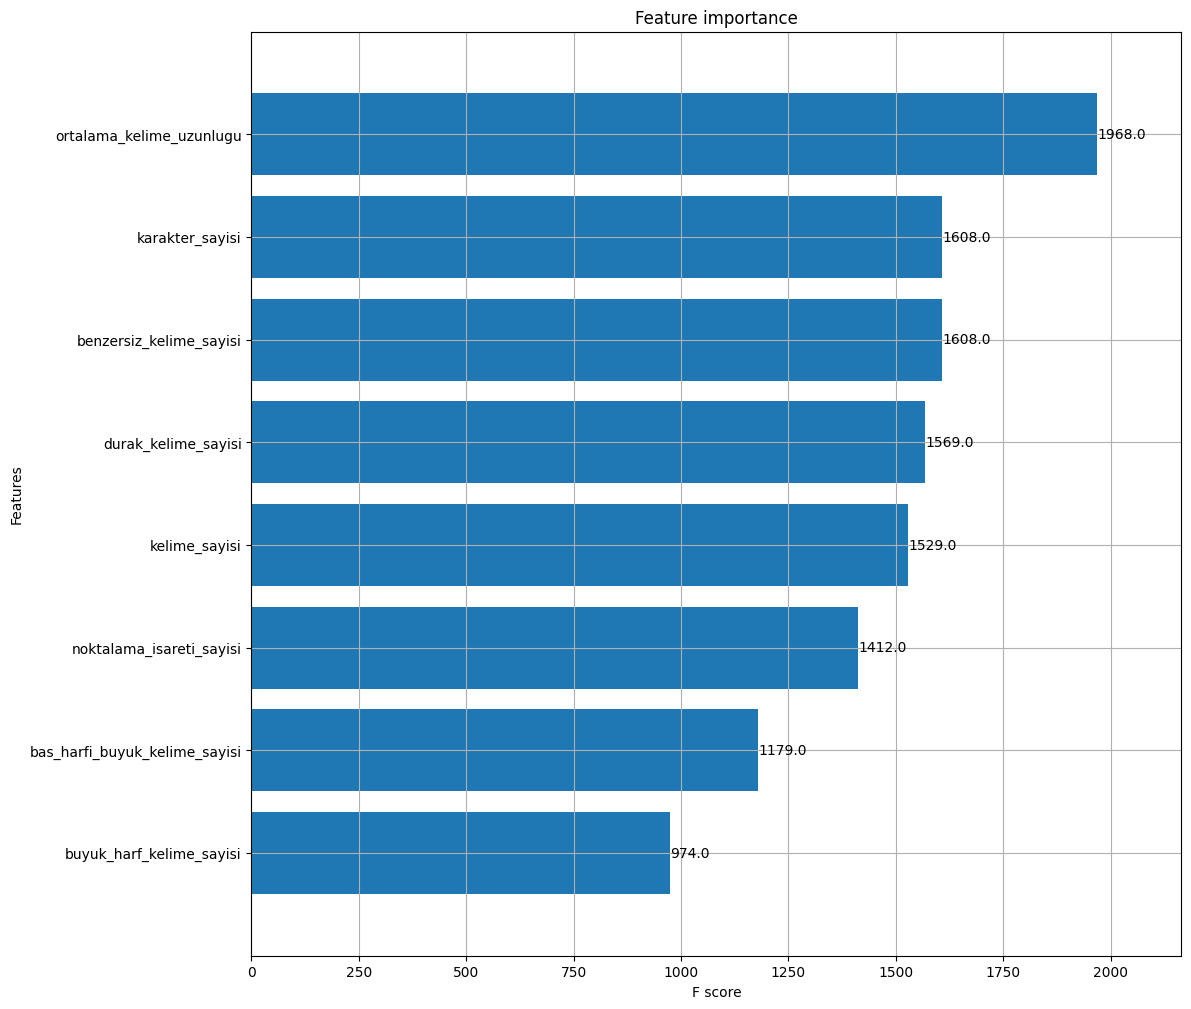

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model =  OneVsRestClassifier(naive_bayes.MultinomialNB(),n_jobs=1)
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score (log-loss): ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score (log-loss):  0.7901561474522394


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

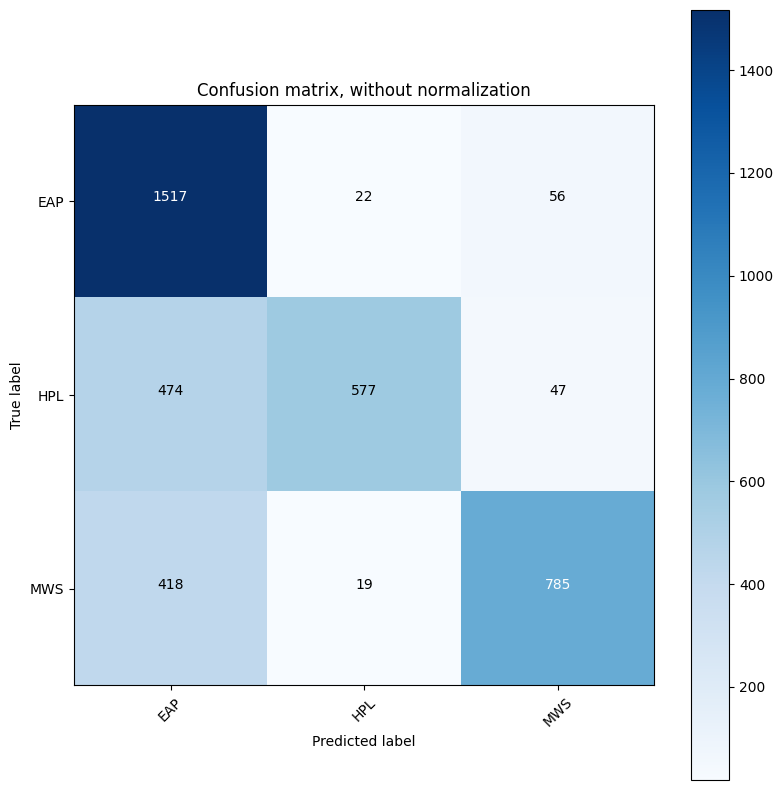

Classification Report:
              precision    recall  f1-score   support

         EAP       0.63      0.95      0.76      1595
         HPL       0.93      0.53      0.67      1098
         MWS       0.88      0.64      0.74      1222

    accuracy                           0.74      3915
   macro avg       0.82      0.71      0.72      3915
weighted avg       0.79      0.74      0.73      3915



In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix, without normalization')
plt.show()
from sklearn.metrics import classification_report
# Classification report
print("Classification Report:")
print(classification_report(val_y, np.argmax(pred_val_y, axis=1), target_names=['EAP', 'HPL', 'MWS']))

In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score (log-loss): ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score (log-loss):  0.4661816440562262


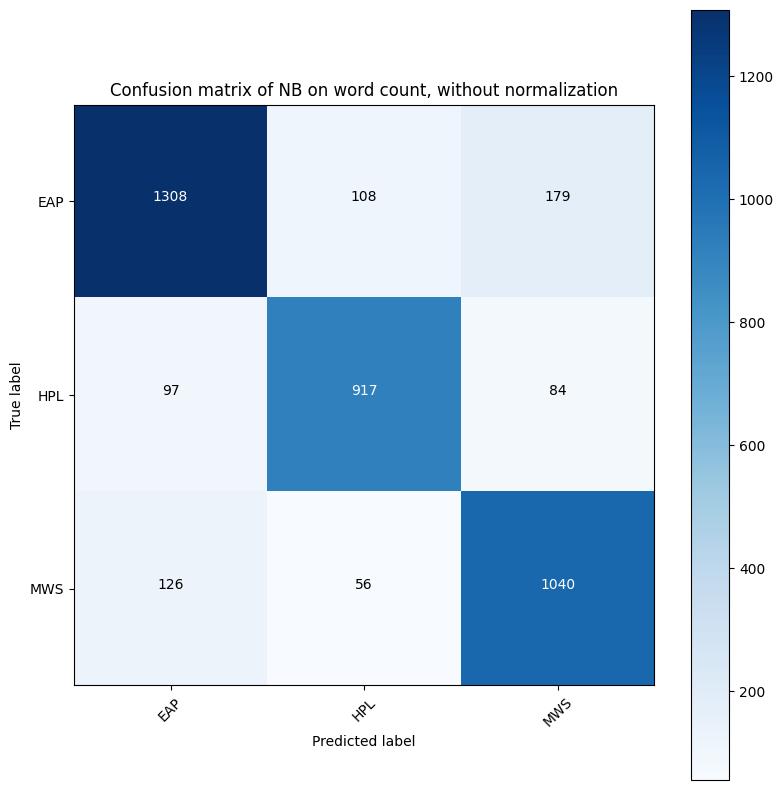

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Classification report
print("Classification Report:")
print(classification_report(val_y, np.argmax(pred_val_y, axis=1), target_names=['EAP', 'HPL', 'MWS']))

Classification Report:
              precision    recall  f1-score   support

         EAP       0.85      0.82      0.84      1595
         HPL       0.85      0.84      0.84      1098
         MWS       0.80      0.85      0.82      1222

    accuracy                           0.83      3915
   macro avg       0.83      0.84      0.83      3915
weighted avg       0.84      0.83      0.83      3915



In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.827618330754279


In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.8095594833863995


In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:23:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.00157	test-mlogloss:1.00104
[20]	train-mlogloss:0.41686	test-mlogloss:0.41716
[40]	train-mlogloss:0.34663	test-mlogloss:0.35340
[60]	train-mlogloss:0.32237	test-mlogloss:0.33676
[80]	train-mlogloss:0.30636	test-mlogloss:0.32791
[100]	train-mlogloss:0.29354	test-mlogloss:0.32233
[120]	train-mlogloss:0.28283	test-mlogloss:0.31889
[140]	train-mlogloss:0.27368	test-mlogloss:0.31641
[160]	train-mlogloss:0.26499	test-mlogloss:0.31443
[180]	train-mlogloss:0.25758	test-mlogloss:0.31302
[200]	train-mlogloss:0.25077	test-mlogloss:0.31170
[220]	train-mlogloss:0.24410	test-mlogloss:0.31128
[240]	train-mlogloss:0.23755	test-mlogloss:0.31063
[260]	train-mlogloss:0.23185	test-mlogloss:0.30957
[280]	train-mlogloss:0.22587	test-mlogloss:0.30898
[300]	train-mlogloss:0.22034	test-mlogloss:0.30843
[320]	train-mlogloss:0.21475	test-mlogloss:0.30778
[340]	train-mlogloss:0.20960	test-mlogloss:0.30815
[360]	train-mlogloss:0.20448	test-mlogloss:0.30779
[380]	train-mlogloss:0.19962	test-mlo

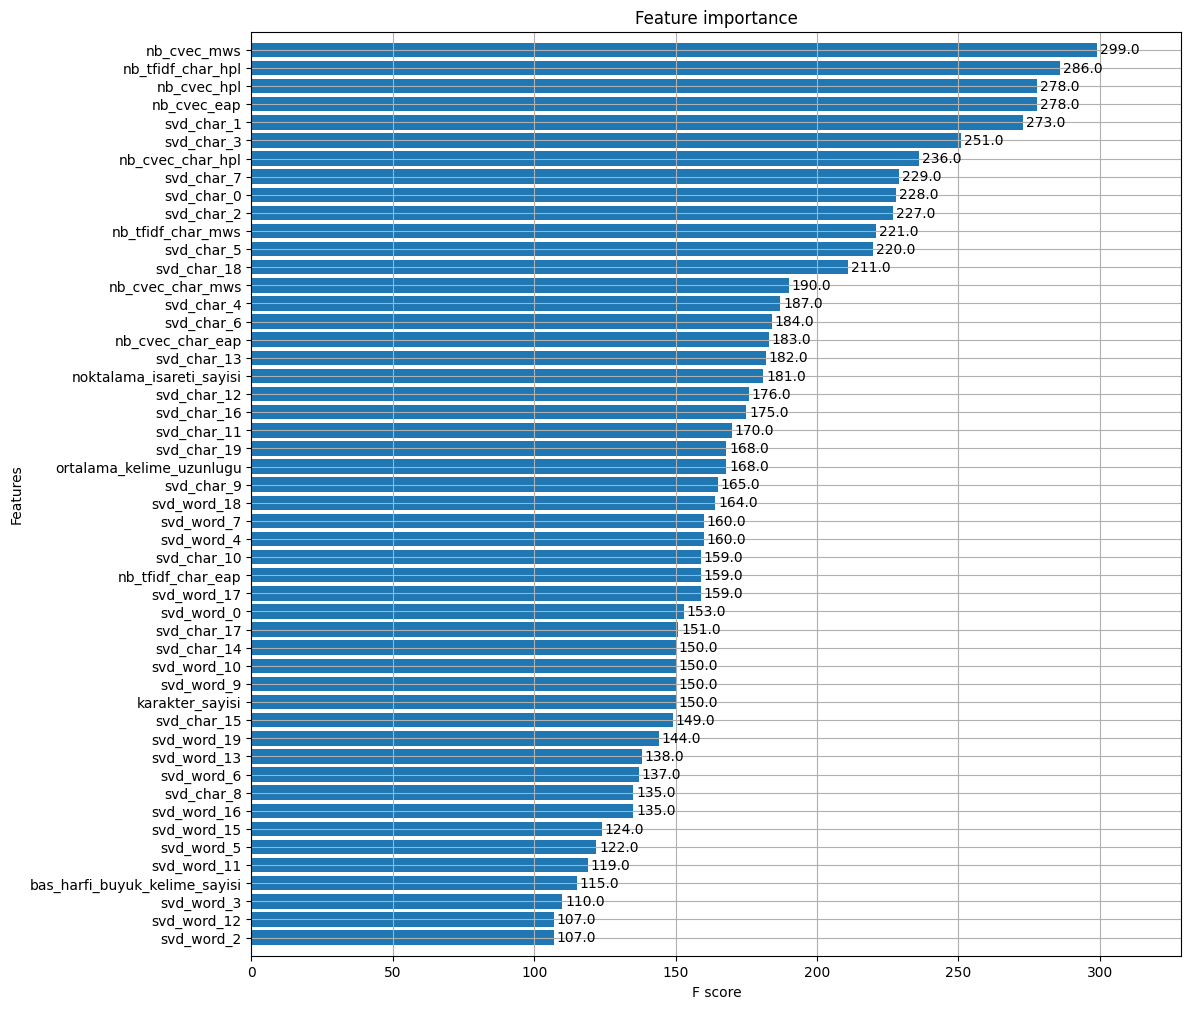

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

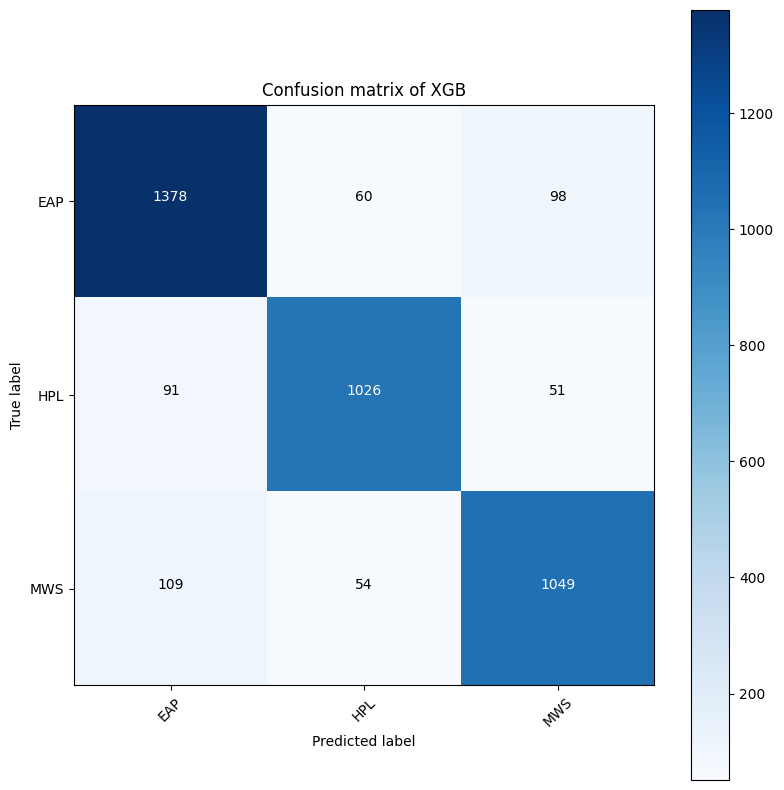

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Classification report
print("Classification Report:")
print(classification_report(val_y, np.argmax(pred_val_y, axis=1), target_names=['EAP', 'HPL', 'MWS']))

Classification Report:
              precision    recall  f1-score   support

         EAP       0.87      0.90      0.89      1536
         HPL       0.90      0.88      0.89      1168
         MWS       0.88      0.87      0.87      1212

    accuracy                           0.88      3916
   macro avg       0.88      0.88      0.88      3916
weighted avg       0.88      0.88      0.88      3916



Random Forest Model Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

         EAP       0.85      0.87      0.86      1570
         HPL       0.87      0.86      0.86      1071
         MWS       0.87      0.85      0.86      1275

    accuracy                           0.86      3916
   macro avg       0.86      0.86      0.86      3916
weighted avg       0.86      0.86      0.86      3916



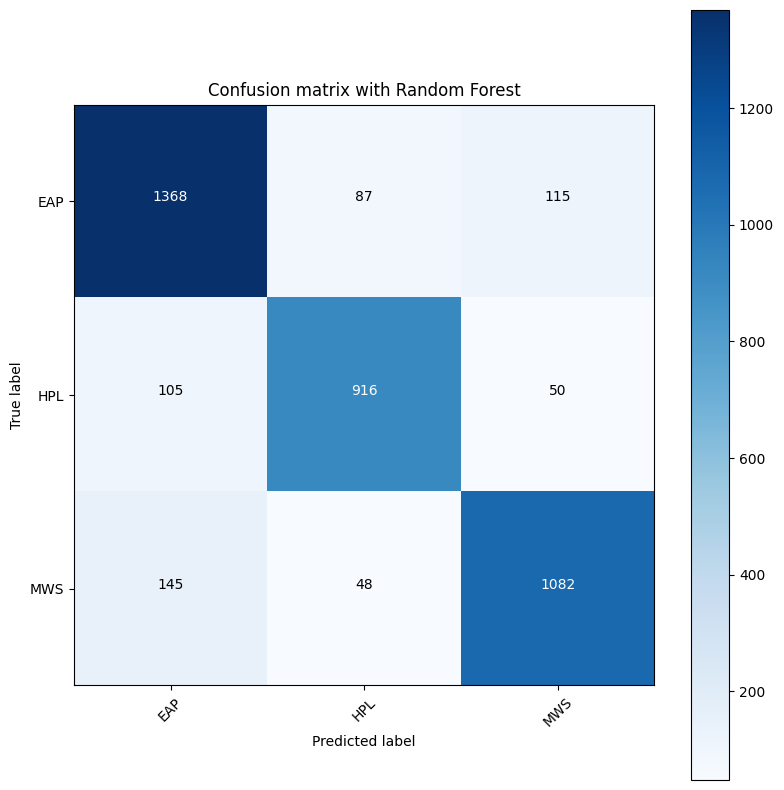

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
# Random Forest Modeli
rf_model = RandomForestClassifier()

# Hyperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_rf_model = grid_search.best_estimator_

# Tahminler
y_pred = best_rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Model Accuracy: {accuracy:.2f}")

# Classification report ve Confusion matrix
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['EAP', 'HPL', 'MWS']))
cnf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix with Random Forest')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Decision Tree Model Accuracy: 0.82
Decision Tree Classification Report:
               precision    recall  f1-score   support

         EAP       0.81      0.84      0.83      1570
         HPL       0.82      0.81      0.82      1071
         MWS       0.84      0.82      0.83      1275

    accuracy                           0.82      3916
   macro avg       0.83      0.82      0.82      3916
weighted avg       0.82      0.82      0.82      3916



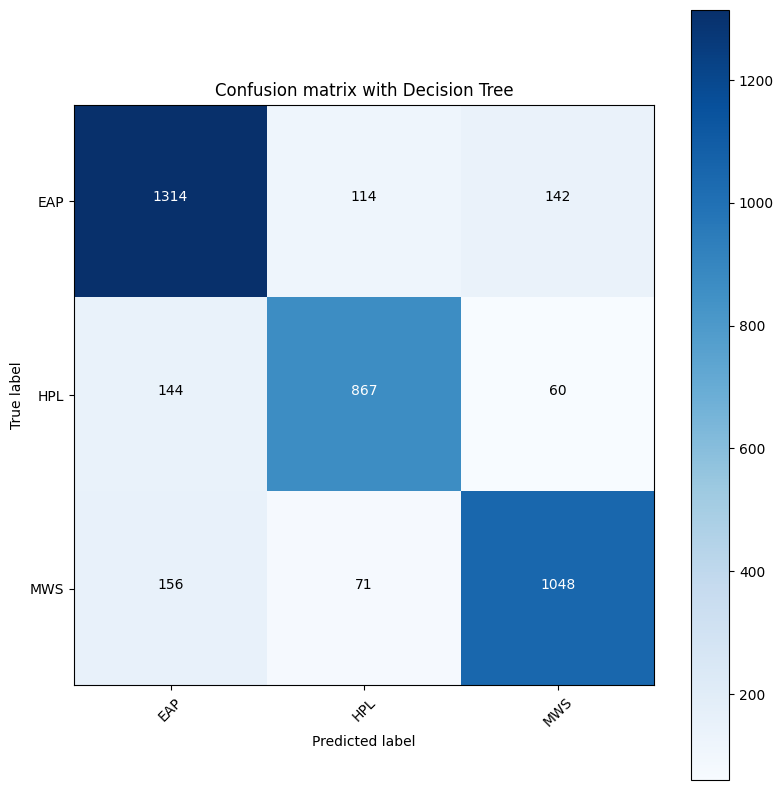

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Veriyi eğitim ve test olarak ayırma
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Standardizasyon
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_X = scaler.transform(test_X)

# Karar Ağacı Modeli
dt_model = DecisionTreeClassifier(random_state=42)

# Hyperparametre optimizasyonu
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# En iyi Karar Ağacı modelini seçme
best_dt_model = grid_search_dt.best_estimator_

# Karar Ağacı Tahminler
y_pred_dt = best_dt_model.predict(X_val)
accuracy_dt = accuracy_score(y_val, y_pred_dt)
print(f"Decision Tree Model Accuracy: {accuracy_dt:.2f}")

# Classification report ve Confusion matrix
print("Decision Tree Classification Report:\n", classification_report(y_val, y_pred_dt, target_names=['EAP', 'HPL', 'MWS']))
cnf_matrix_dt = confusion_matrix(y_val, y_pred_dt)

# Confusion matrix çizme
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix_dt, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix with Decision Tree')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Logistic Regression Model Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

         EAP       0.85      0.87      0.86      1570
         HPL       0.88      0.85      0.87      1071
         MWS       0.86      0.86      0.86      1275

    accuracy                           0.86      3916
   macro avg       0.86      0.86      0.86      3916
weighted avg       0.86      0.86      0.86      3916



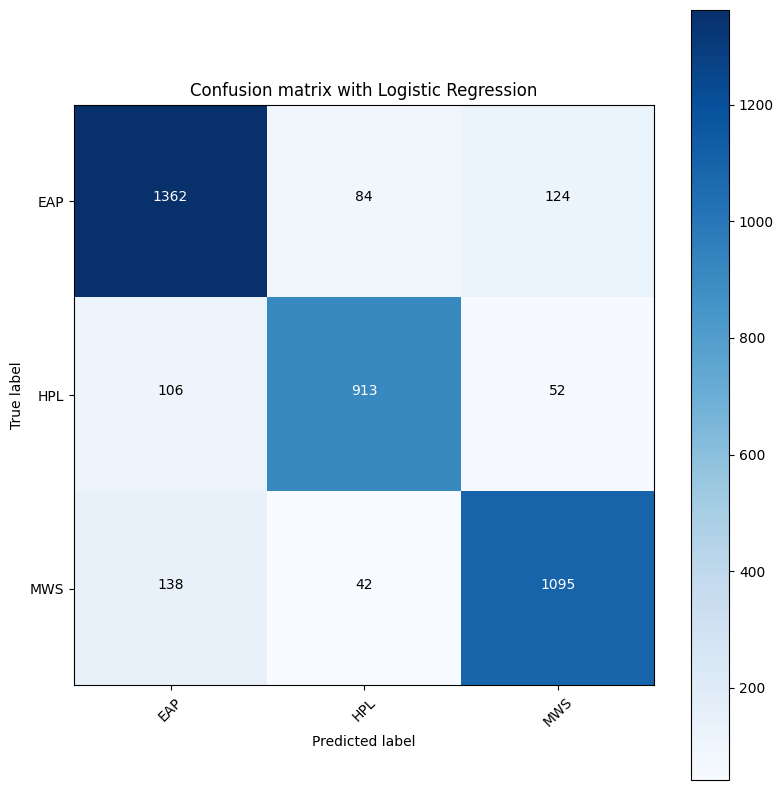

In [ ]:
from sklearn.linear_model import LogisticRegression
# Veriyi eğitim ve test olarak ayırma
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Standardizasyon
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_X = scaler.transform(test_X)

# Logistic Regression Modeli
log_reg_model = LogisticRegression()

# Hyperparametre optimizasyonu
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Parametre aralığı
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_log_reg_model = grid_search.best_estimator_

# Tahminler
y_pred = best_log_reg_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.2f}")

# Classification report ve Confusion matrix
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['EAP', 'HPL', 'MWS']))
cnf_matrix = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix with Logistic Regression')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


XGBoost Model Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

         EAP       0.86      0.87      0.86      1570
         HPL       0.87      0.87      0.87      1071
         MWS       0.87      0.85      0.86      1275

    accuracy                           0.86      3916
   macro avg       0.87      0.86      0.86      3916
weighted avg       0.86      0.86      0.86      3916



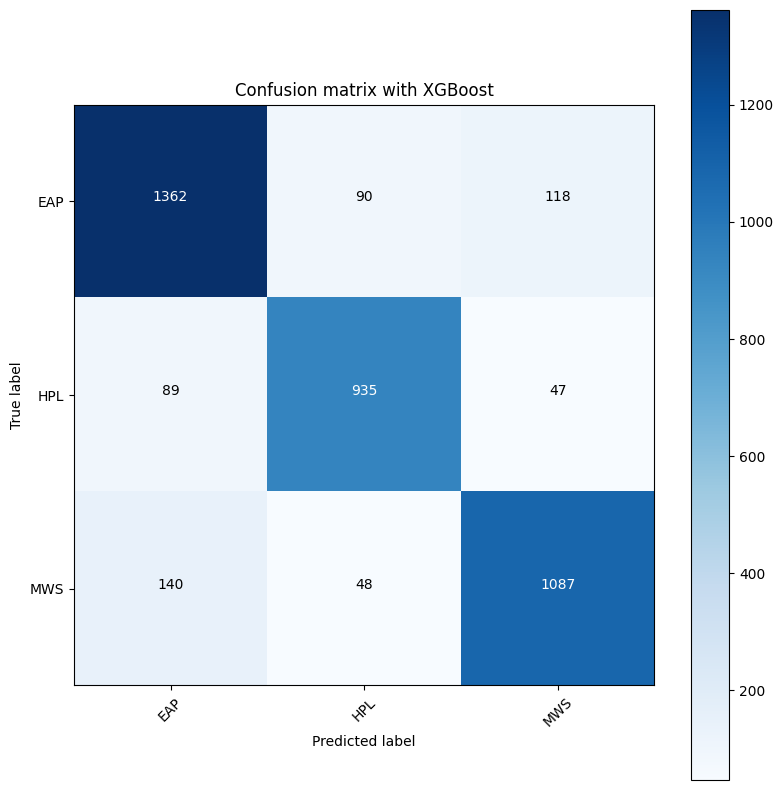

In [ ]:
from xgboost import XGBClassifier
# Veriyi eğitim ve test olarak ayırma
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Standardizasyon
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_X = scaler.transform(test_X)

# XGBoost Modeli
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Hyperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_xgb_model = grid_search.best_estimator_

# Tahminler
y_pred = best_xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.2f}")

# Classification report ve Confusion matrix
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['EAP', 'HPL', 'MWS']))
cnf_matrix = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix with XGBoost')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Naive Bayes Model Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

         EAP       0.85      0.84      0.84      1570
         HPL       0.86      0.82      0.84      1071
         MWS       0.83      0.86      0.85      1275

    accuracy                           0.84      3916
   macro avg       0.84      0.84      0.84      3916
weighted avg       0.84      0.84      0.84      3916



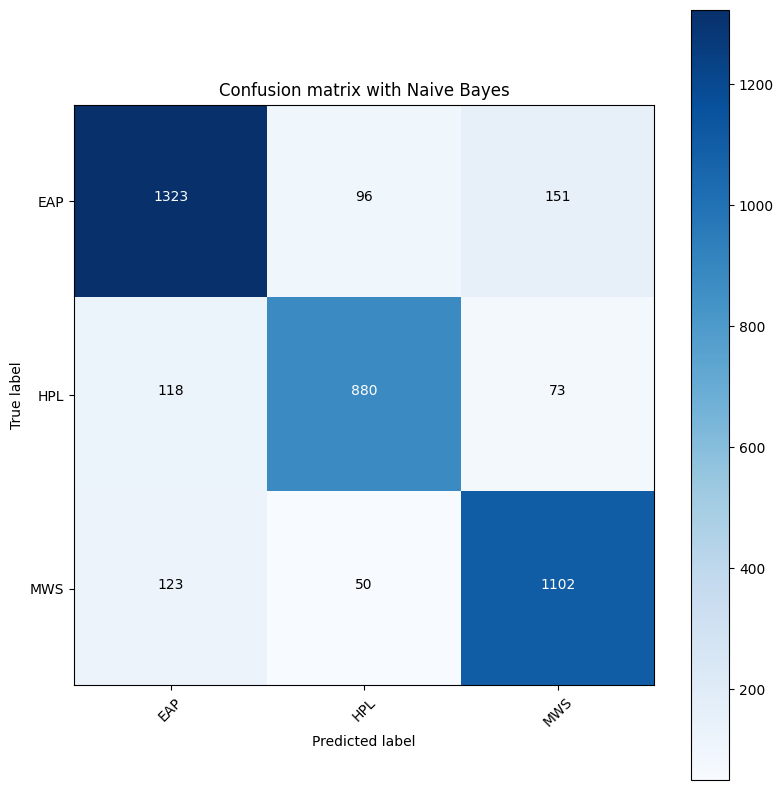

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
# Veriyi eğitim ve test olarak ayırma
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Standardizasyon
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_X = scaler.transform(test_X)

# Naive Bayes Modeli
nb_model = MultinomialNB()

# Hyperparametre optimizasyonu
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Parametre aralığı
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi modeli seçme
best_nb_model = grid_search.best_estimator_

# Tahminler
y_pred = best_nb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Naive Bayes Model Accuracy: {accuracy:.2f}")

# Classification report ve Confusion matrix
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['EAP', 'HPL', 'MWS']))
cnf_matrix = confusion_matrix(y_val, y_pred)


plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'], title='Confusion matrix with Naive Bayes')
plt.show()